In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import torch
from pathlib import Path
from datetime import datetime
from utils.sim_utils import *
from utils.train_utils import *
from utils.vec_sim_utils import *
from utils.encoder_utils import *
from utils.dataset_utils import *
from utils.mmd_loss import MMDLoss
from models.Generator import ModularPolicy
from models.Discriminator import Discriminator

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
window_len = 10
window_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\windows\{window_len} windows'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pred_files = []
prey_files = []

# load expert tensors from files
for file in os.listdir(window_path):
    if file.startswith("pred"):
        pred_tensor = torch.load(os.path.join(window_path, file))
        pred_files.append(pred_tensor)
    elif file.startswith("prey"):
        prey_tensor = torch.load(os.path.join(window_path, file))
        prey_files.append(prey_tensor)

# concatenate all tensors
exp_pred_tensor = torch.cat(pred_files, dim=0).type(torch.float32)
exp_prey_tensor = torch.cat(prey_files, dim=0).type(torch.float32)

print("Pred Tensor Shape:", exp_pred_tensor.shape)
print("Prey Tensor Shape:", exp_prey_tensor.shape)

# load initial pool
init_pool_path = rf"..\data\1. Data Processing\processed\init_pool\init_pool.pt"
init_pool = torch.load(init_pool_path).to(device)

Pred Tensor Shape: torch.Size([793, 10, 1, 32, 5])
Prey Tensor Shape: torch.Size([793, 10, 32, 32, 6])


epoch 010: loss=23.031837 sim=0.0514 std=1.3036 cov=0.4384 std_mean=0.348
epoch 020: loss=21.905460 sim=0.0356 std=1.2735 cov=0.3826 std_mean=0.363
epoch 030: loss=21.267612 sim=0.0361 std=1.1999 cov=0.4735 std_mean=0.400
epoch 040: loss=20.780142 sim=0.0372 std=1.1686 cov=0.4642 std_mean=0.416
epoch 050: loss=20.305607 sim=0.0402 std=1.1324 cov=0.4631 std_mean=0.434
epoch 060: loss=20.235165 sim=0.0406 std=1.1027 cov=0.5360 std_mean=0.449
epoch 070: loss=19.713928 sim=0.0406 std=1.0713 cov=0.5256 std_mean=0.464
epoch 080: loss=19.527815 sim=0.0452 std=1.0415 cov=0.5547 std_mean=0.479
epoch 090: loss=19.516918 sim=0.0508 std=1.0458 cov=0.5122 std_mean=0.477
epoch 100: loss=19.240265 sim=0.0445 std=1.0157 cov=0.5785 std_mean=0.492
epoch 110: loss=18.951893 sim=0.0455 std=0.9840 cov=0.6110 std_mean=0.508
epoch 120: loss=18.706226 sim=0.0482 std=0.9775 cov=0.5680 std_mean=0.511
epoch 130: loss=18.594625 sim=0.0526 std=0.9686 cov=0.5502 std_mean=0.516
epoch 140: loss=18.542032 sim=0.0569 s

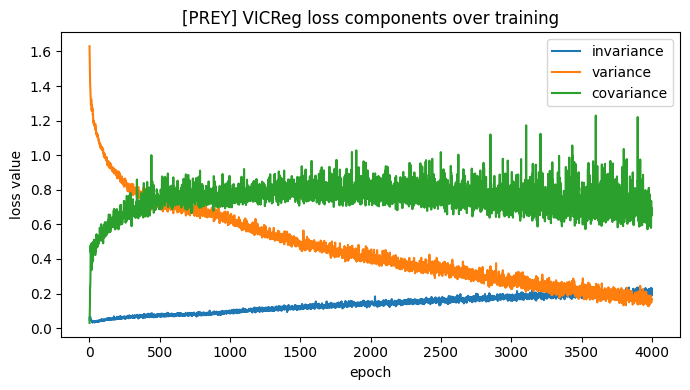

epoch 010: loss=23.492769 sim=0.0404 std=1.3684 cov=0.3914 std_mean=0.316
epoch 020: loss=22.778002 sim=0.0447 std=1.3018 cov=0.4268 std_mean=0.349
epoch 030: loss=23.074076 sim=0.0415 std=1.2980 cov=0.5134 std_mean=0.351
epoch 040: loss=21.857613 sim=0.0239 std=1.3038 cov=0.3407 std_mean=0.348
epoch 050: loss=21.692587 sim=0.0417 std=1.2226 cov=0.4623 std_mean=0.389
epoch 060: loss=21.182446 sim=0.0219 std=1.2569 cov=0.3561 std_mean=0.372
epoch 070: loss=22.194765 sim=0.0579 std=1.2412 cov=0.4260 std_mean=0.379
epoch 080: loss=21.240816 sim=0.0368 std=1.2065 cov=0.4446 std_mean=0.397
epoch 090: loss=21.275482 sim=0.0398 std=1.2344 cov=0.3529 std_mean=0.383
epoch 100: loss=21.199007 sim=0.0340 std=1.2025 cov=0.4620 std_mean=0.399
epoch 110: loss=21.204491 sim=0.0300 std=1.2228 cov=0.4223 std_mean=0.389
epoch 120: loss=21.588533 sim=0.0585 std=1.1881 cov=0.4606 std_mean=0.406
epoch 130: loss=20.335308 sim=0.0203 std=1.1531 cov=0.5063 std_mean=0.423
epoch 140: loss=21.398716 sim=0.0253 s

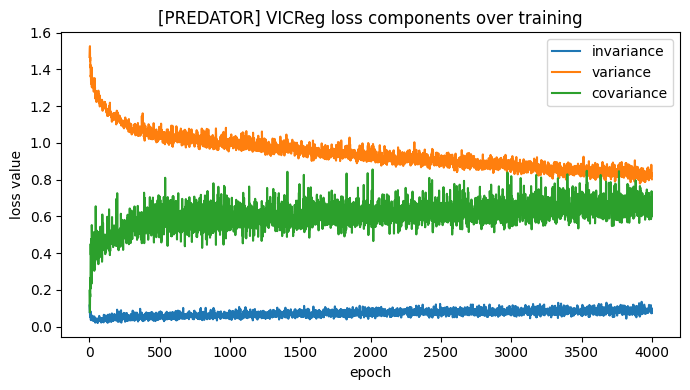

In [3]:
# initialize trajectory augmentation
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)

# pretrain prey encoder
prey_encoder = TransitionEncoder(features=5, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=4000, optimizer=prey_optimizer, role="prey")
torch.save(prey_encoder.state_dict(), rf"..\models\trained_policies\Encoder\prey_encoder.pt")

# pretrain predator encoder
pred_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
pred_projector = VicRegProjector(input_dim=64).to(device)
pred_optimizer = torch.optim.Adam(list(pred_encoder.parameters()) + list(pred_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(pred_encoder, pred_projector, aug=aug, exp_tensor=exp_pred_tensor, epochs=4000, optimizer=pred_optimizer, role="predator") 
torch.save(pred_encoder.state_dict(), rf"..\models\trained_policies\Encoder\pred_encoder.pt")

[PREDATOR] Epoch 25/2000 | train_loss:0.013332 | val_loss:0.012592
[PREDATOR] Epoch 50/2000 | train_loss:0.012776 | val_loss:0.012211
[PREDATOR] Epoch 75/2000 | train_loss:0.011741 | val_loss:0.011603
[PREDATOR] Epoch 100/2000 | train_loss:0.010964 | val_loss:0.011161
[PREDATOR] Epoch 125/2000 | train_loss:0.010229 | val_loss:0.010619
[PREDATOR] Epoch 150/2000 | train_loss:0.009516 | val_loss:0.010208
[PREDATOR] Epoch 175/2000 | train_loss:0.008810 | val_loss:0.009471
[PREDATOR] Epoch 200/2000 | train_loss:0.008272 | val_loss:0.009004
[PREDATOR] Epoch 225/2000 | train_loss:0.007802 | val_loss:0.008536
[PREDATOR] Epoch 250/2000 | train_loss:0.007341 | val_loss:0.008261
[PREDATOR] Epoch 275/2000 | train_loss:0.006858 | val_loss:0.007757
[PREDATOR] Epoch 300/2000 | train_loss:0.006490 | val_loss:0.007359
[PREDATOR] Epoch 325/2000 | train_loss:0.006006 | val_loss:0.006993
[PREDATOR] Epoch 350/2000 | train_loss:0.005692 | val_loss:0.006695
[PREDATOR] Epoch 375/2000 | train_loss:0.005429 | v

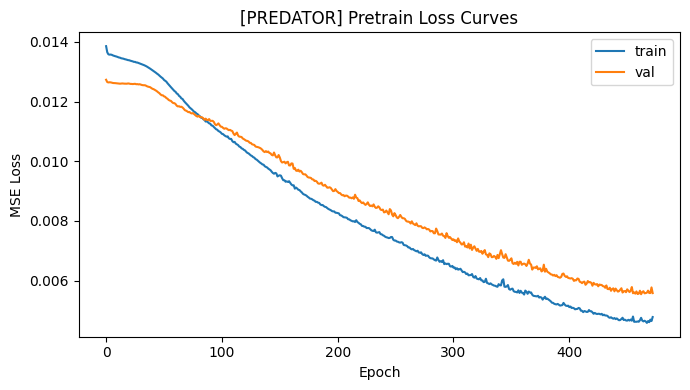

[PREY] Epoch 25/2000 | train_loss:0.036798 | val_loss:0.037335
[PREY] Epoch 50/2000 | train_loss:0.036203 | val_loss:0.036904
[PREY] Epoch 75/2000 | train_loss:0.035692 | val_loss:0.036442
[PREY] Epoch 100/2000 | train_loss:0.035118 | val_loss:0.036110
[PREY] Epoch 125/2000 | train_loss:0.034629 | val_loss:0.035656
[PREY] Epoch 150/2000 | train_loss:0.034144 | val_loss:0.035279
[PREY] Epoch 175/2000 | train_loss:0.033652 | val_loss:0.034844
[PREY] Early stopping at epoch 185.


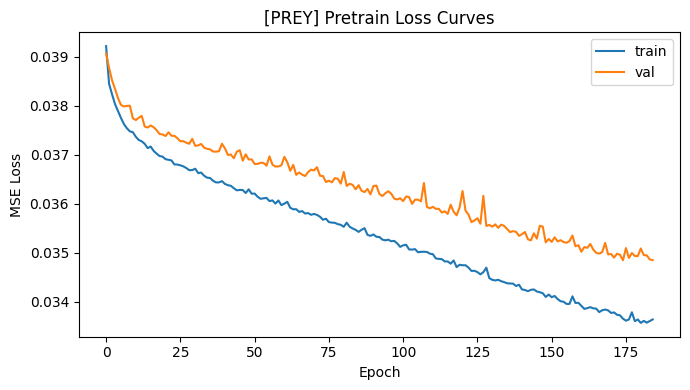

In [5]:
# pretrain predator policy with behavior cloning and early stopping
pred_policy = ModularPolicy(features=4).to(device)
pretrain_policy(pred_policy, role="predator", expert_data=exp_pred_tensor, 
                batch_size=4048, epochs=2000, lr=1e-3, patience=10,
                deterministic=True, device=device)
torch.save(pred_policy.state_dict(), rf"..\models\trained_policies\BC-Policy\bc_pred_policy.pt")


# pretrain prey policy with behavior cloning and early stopping
prey_policy = ModularPolicy(features=5).to(device)
pretrain_policy(prey_policy, role="prey", expert_data=exp_prey_tensor, 
                batch_size=4048, epochs=2000, lr=1e-3, patience=10,
                deterministic=True, device=device)
torch.save(prey_policy.state_dict(), rf"..\models\trained_policies\BC-Policy\bc_prey_policy.pt")

In [ ]:
%matplotlib tk
# run a simulation with the pretrained policies
gen_pred_tensor, gen_prey_tensor, metrics = run_env_simulation(visualization='on', 
                                                      prey_policy=prey_policy, pred_policy=pred_policy,
                                                      n_prey=32, n_pred=1, 
                                                      pred_speed=10, prey_speed=10,
                                                      max_steps=100, step_size=1, 
                                                      area_width=2160, area_height=2160, 
                                                      max_turn=0.314,
                                                      init_pool=init_pool)